## Zbiory rozmyte

W logice, z którą państwo mieli dotychczas do czynienia, zazwyczaj występują jednoznaczne zależności, np. element x albo należy do zbioru X, albo do niego nie należy, a zdanie posiada wartość logiczną 0 lub 1.

Modelując różne zjawiska, często musimy zamieniać "ludzką" percepcję, obarczoną zawsze wieloma nieścisłościami, na "ścisłą". W rzeczywistości proste przełożenie niedokładnych pojęć takich jak "ciepłe", "zimne", "szybki", "dokładna" na zakresy liczb może wiązać się z bardzo dużym błędem.

Jedną z propozycji obejścia tego problemu jest zaproponowana przez Lofti Zadeha __logika rozmyta__, w której raczej niż przypisywać elementy do zbiorów w sposób jednocznaczny definiujemy jakąś funkcję przynależności, która może przyjąć rzeczywiste wartości z zakresu od 0 (w ogóle nie należy) do 1 (całkowicie należy). 

__Przykład:__ wyobraźmy sobie, że chcemy zamienić temperaturę na przedziały "zimno", "ciepło" i "gorąco". Bez logiki rozmytej musielibyśmy postawić jednoznaczne granice tych przedziałów, podczas, gdy np. w wypadku 26°C część ludzi stwierdzi, że to jeszcze ciepło, a część, że już gorąco. Budujemy więc zbiory rozmyte, które mogą wyglądać np. tak:

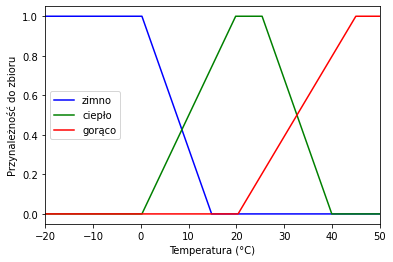

## Wnioskowanie rozmyte

Wnioskowanie rozmyte wykorzystuje zbiory rozmyte, żeby przekładać "ludzką" wiedzę na matematyczne narzędzia wnioskowania. Przykładowe wnioskowanie rozmyte może dotyczyć np. klimatyzacji. Na początku układamy jakiś zestaw reguł rozmytych:

* Jeżeli jest _zimno_, to ustaw moc klimatyzacji na _niską_

* Jeżeli jest _ciepło_ i _sucho_, to ustaw moc klimatyzacji na _średnią_

* Jeżeli jest _ciepło_ i _wilgotno_ to ustaw moc klimatyzacji na _wysoką_

Jak widzimy, są to reguły zapisane bez konkretnych funkcji matematycznych, a bardziej w sposób odzwierciedlający ludzką intuicję czy wiedzę. Zbiór zasad rozmytych zawsze układamy w sposób:

"Jeżeli WARUNKI to EFEKT"

Na podstawie tych reguł i odpowiedniego ułożenia zbiorów rozmytych będziemy dokonywać wnioskowania. Teraz powiedzmy, że mamy już jakieś faktyczne dane dotyczące temperatury i wilgotności. Musimy:

1. Dokonać __fuzyfikacji (rozmycia)__ wejść liczbowych, tzn. obliczyć ich przynależność do poszczególnych zbiorów rozmytych

2. Przeprowadzić __wnioskowanie__, zgodnie ze zbiorem reguł

3. Dokonać __defuzyfikacji__ wyniku, czyli wrócić do danych liczbowych.

### Zastosowania

Wnioskowanie rozmyte można stosować w trzech dużych zagadnieniach:

* W sterowaniu (np. klimatyzacją, hamulcami, poziomem uchyłu okna, temperaturą pieca, ruchami statku)

* W predykcji (np. poziomu zanieczyszczeń, promocji w sklepie, stanu rynku, poziomu przestępczości)

* Jako mechanizm pomocniczy dla innych zagadnień z uczenia maszynowego (np. w sieciach neuronowych)

W wielu językach programowania można znaleźć biblioteki/pakiety służące do pracy z wnioskowaniem rozmytym. My proponujemy skorzystać z skfuzzy dla pythona, kompatybilnego ze scikitem. Musimy go sobie najpierw pobrać:

In [5]:
!pip install scikit-fuzzy

Defaulting to user installation because normal site-packages is not writeable


W prostym przykładzie powiedzmy, że interesuje nas sterowanie temperaturą w dużej galerii handlowej w zimie. Ogrzewanie pomaga przyciągnąć klientów na dłużej (nie chce im się wychodzić), generuje jednak znaczne koszty (zwłaszcza w tak dużym budynku jak galeria handlowa). Powiedzmy, że będziemy brać pod uwagę ilość klientów (mało, dużo) i porę dnia (wcześnie, późno). W kategoriach temperatury może być "ciepło" lub "zimno".

__Zestaw reguł:__

* Jeżeli jest _mało ludzi_, to utrzymaj _zimno_

* Jeżeli jest _późno_ lub jest _dużo ludzi_, to utrzymaj _ciepło_

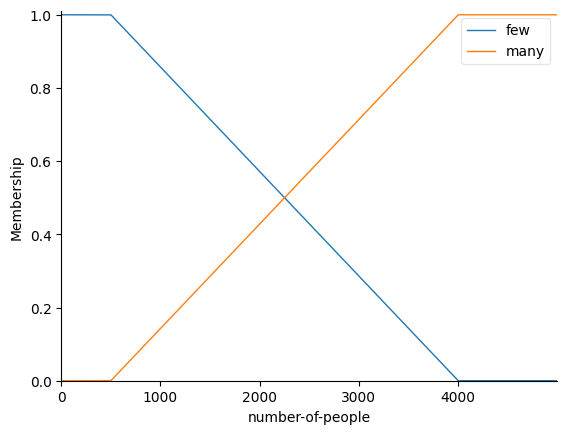

In [68]:
# zaimportujmy nasze pakiety:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

# ilość ludzi w zakresie [0, 5k]
number_of_people = ctrl.Antecedent(np.arange(0, 5000, 1),'number-of-people')

# godzina w zakresie [8, 22] (powiedzmy, że takie są godziny otwarcia galerii)
hour = ctrl.Antecedent(np.arange(8, 22, 0.1),'hour')

# cel termostatu w zakresie [14, 23] (powiedzmy, że tyle stopni możemy osiągnąć)
heating  = ctrl.Consequent(np.arange(14, 23, 0.1),'heating')

# skorzystamy z funkcji trapezoidalnej (trapmf, trap-membership-function) przy określaniu przynależności do zbiorów

number_of_people['few'] = fuzz.trapmf(number_of_people.universe, [0, 0, 500, 4000])
number_of_people['many'] = fuzz.trapmf(number_of_people.universe,[500,4000,5000,5000])

hour['early'] = fuzz.trapmf(hour.universe, [8,8,11,18])
hour['late'] = fuzz.trapmf(hour.universe, [11,18,22,22])

heating['cool'] = fuzz.trapmf(heating.universe,[14,14,16,21])
heating['warm'] = fuzz.trapmf(heating.universe,[16,21,23,23])

# używamy teraz wbudowanej funkcji do wyświetlania:

number_of_people.view()

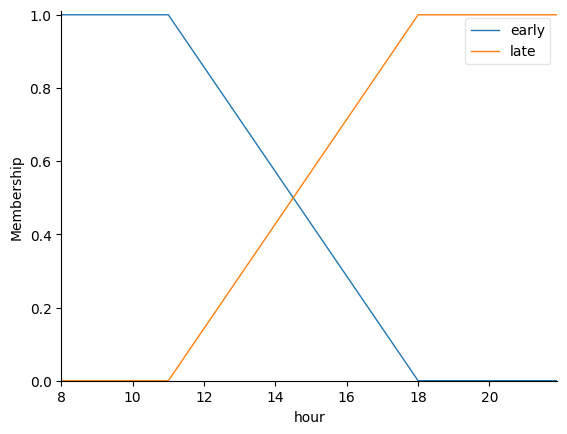

In [7]:
hour.view()

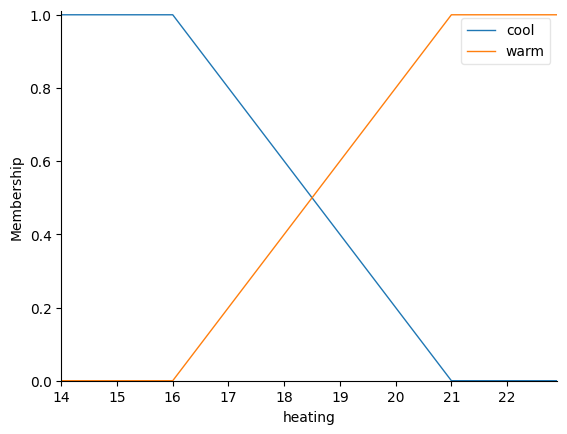

In [8]:
heating.view()

In [69]:
# teraz stwórzmy zestaw zasad:
rule1 = ctrl.Rule(number_of_people['few'], heating['cool']) # jeżeli jest mało ludzi, to utrzymaj chłodno
rule2 = ctrl.Rule(number_of_people['many'] | hour['late'], heating['warm']) # jeżeli jest dużo ludzi lub jest późno, to utrzymaj ciepło

control_system = ctrl.ControlSystem([rule1, rule2])

model = ctrl.ControlSystemSimulation(control_system)

Model proponuje temperaturę:  19.62730143789607


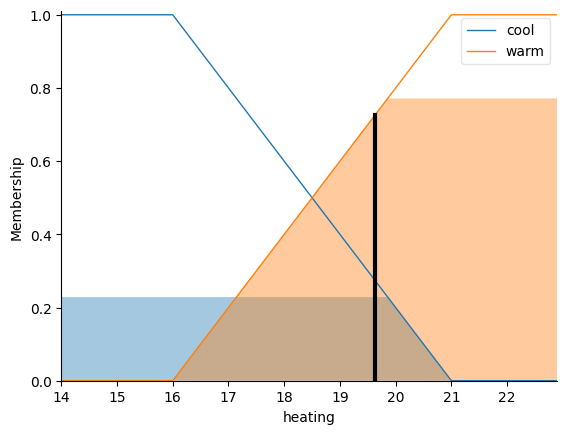

In [70]:
# możemy już przejść do faktycznego wykorzystywania wyniku
# powiedzmy, że jest godzina 13:30 i w galerii jest 3200 ludzi
model.input['number-of-people'] = 3200
model.input['hour'] = 13.5

# oblicz:
model.compute()

# wypisz wynik i przedstaw wynik graficznie:
print('Model proponuje temperaturę: ',model.output['heating'])
heating.view(sim=model)

<Axes: xlabel='number-of-people', ylabel='hour'>

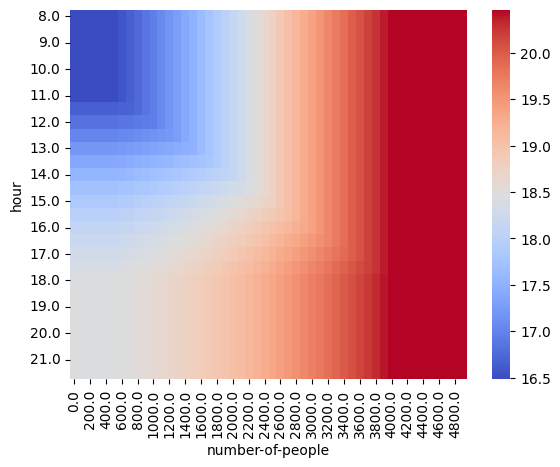

In [71]:
# możemy narysować wyniki dla różnych wejść np. na heatmapie:
import seaborn as sns
import pandas as pd
import numpy as np

people_grid, hour_grid = np.meshgrid(np.arange(0,5000,100), np.arange(8, 22, 0.5))
test_points = np.transpose(np.vstack((np.ravel(people_grid),np.ravel(hour_grid))))

model.input['number-of-people'] = test_points[:,0]
model.input['hour'] = test_points[:,1]
model.compute()

test_points = np.concatenate((test_points, model.output['heating'].reshape(-1,1)), axis=1)

sns.heatmap(pd.DataFrame(test_points, columns = ['number-of-people','hour','heating']).pivot(index='hour', columns='number-of-people', values='heating'), cmap = 'coolwarm')

In [73]:
test_points[:,0]
test_points[:,1]

array([ 8. ,  8. ,  8. , ..., 21.5, 21.5, 21.5])

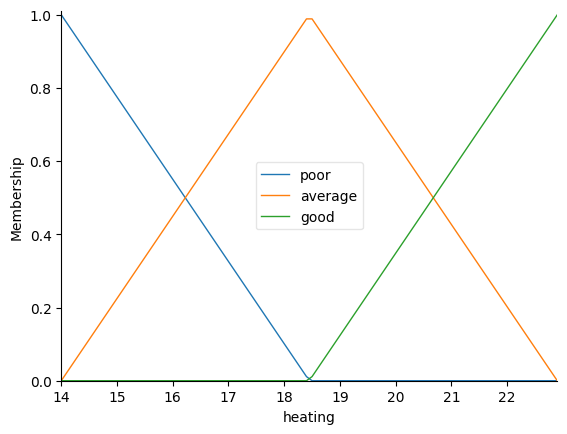

In [ ]:
# skfuzzy udostępnia funkcje do automatycznego dzielenia zbioru na funkcje przynależności.
# nazywa je generycznie, tj. poor, mediocore, average, decent, good.
# można w skfuzzy automatycznie stworzyć 3, 5 lub 7 funkcji przynależności

heating.automf(3)
heating.view()

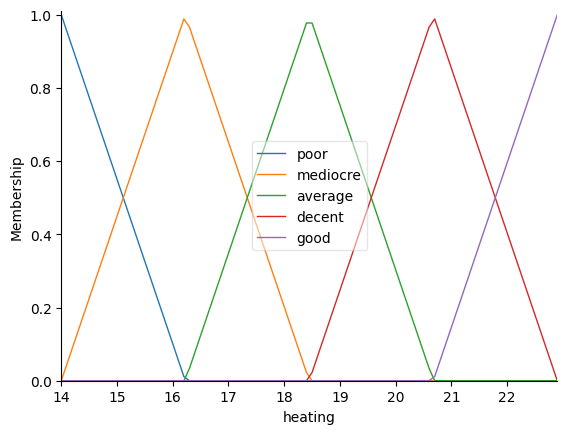

In [ ]:
heating.automf(5)
heating.view()

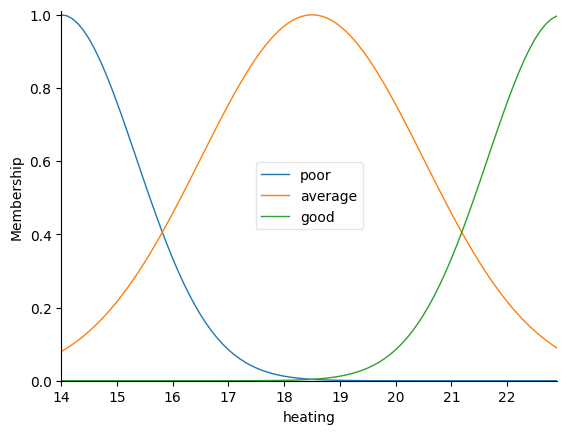

In [ ]:
# możemy też oczywiście użyć gaussowskich funkcji przynależności

heating_gauss  = ctrl.Consequent(np.arange(14, 23, 0.1),'heating')

heating_gauss['poor'] = fuzz.gaussmf(heating_gauss.universe, 14, 1.35)
heating_gauss['average'] = fuzz.gaussmf(heating_gauss.universe, 18.5, 2.0)
heating_gauss['good'] = fuzz.gaussmf(heating_gauss.universe, 23, 1.35)
heating_gauss.view()

## Zadania do samodzielnego wykonania:
1.

Proszę zaprojektować rozmyty system sterowania automatycznym podlewaniem grządki. Grządka ma 3m^2, a system podlewania może nawadniać w tempie maksymalnie 25l/dziennie, podczas, gdy zalecana ilość wody dla "zwyczajnych" warunków dla grządki w takim rozmiarze to 10l/dziennie.

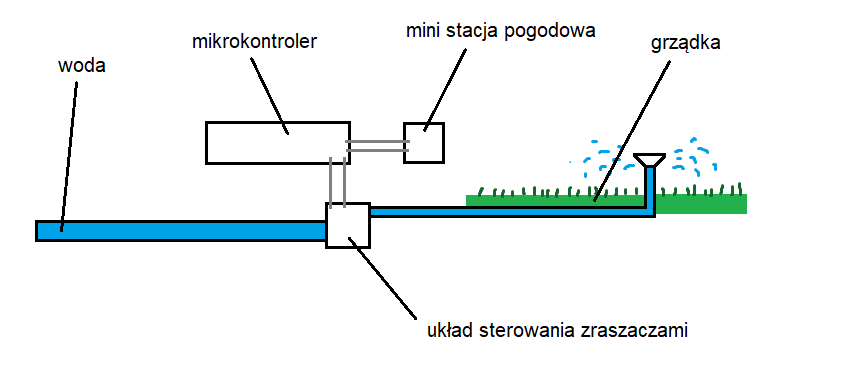

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) i termometr. Temperatury są mierzone wyłącznie za dnia i znajdują się w zakresie 15°C - 35°C.Proszę zaprojektować układ rozmytego sterowania, układając reguły na podstawie następującej tabelki:

|                 | B. sucho             | Sucho                | Przeciętnie      | Mokro            | B. mokro     |
|-----------------|----------------------|----------------------|------------------|------------------|--------------|
| **Chłodno**     | Podlewaj dużo        | Podlewaj średnio     | Podlewaj mało    | Nie podlewaj     | Nie podlewaj |
| **Przeciętnie** | Podlewaj dużo        | Podlewaj średnio     | Podlewaj średnio | Podlewaj mało    | Nie podlewaj |
| **Ciepło**      | Podlewaj dużo        | Podlewaj dużo        | Podlewaj średnio | Podlewaj mało    | Nie podlewaj |
| **Gorąco**      | Podlewaj maksymalnie | Podlewaj dużo        | Podlewaj dużo    | Podlewaj mało    | Podlewaj mało |
| **B. gorąco**   | Podlewaj maksymalnie | Podlewaj maksymalnie | Podlewaj dużo    | Podlewaj średnio | Podlewaj mało |

Proszę samodzielnie zaproponować rozmyte funkcje przynależności i narysować je na wykresach. Proszę przedstawić heatmapę wynikowej funkcji ilości wody używanej dziennie w zależności od wilgotności i temperatury ukrytej w mechanizmie sterowania.

2.

Proszę zastanowić się, jaką dodatkową zmienną można wprowadzić do systemu, np. oczekiwany poziom deszczu następnego dnia, wilgotność gleby, nasłonecznienie. Problem jest praktyczny, więc proszę zastanowić się przede wszystkim nad takimi zmiennymi, które da się zmierzyć używając elektroniki lub pobrać z jakiegoś internetowego API (np. pogodowego). Proszę ustalić dla tej zmiennej jednostkę, zaproponować jej przynależność do zbiorów rozmytych oraz reguły wnioskowania. Proszę przedstawić co najmniej 4 heatmapy zależności nadawniania od temperatury i wilgotności dla 4 wartości zaproponowanej przez państwa zmiennej. Proszę też podać, jakim czujnikiem lub z jakiego API można pobrać te dane.

3.

Proszę pobrać plik dane_pogodowe.csv, który zawiera średnie dzienne pomiary pogodowe z lat 2020-2022 ze stacji meteorologicznej stojącej na dachu budynku D-10. Proszę zaproponować mechanizm rozumowania rozmytego, który weźmie pod uwagę: średnią temperaturę dobową, średnią prędkość wiatru, średnią względną wilgotność i nagromadzenie deszczu w celu przewidywania zanieczyszczenia pyłem PM10. Przykładowa reguła: "jeżeli danego dnia jest zimno i nie ma wiatru, to zanieczyszczenie będzie duże".

Szczególnie przy projektowaniu funkcji dla ilości deszczu proszę być bardzo ostrożnym, zbiór "braku deszczu" powinien wyglądać inaczej niż pozostałe zbiory.

Proszę ocenić jakość mechanizmu (mają państwo dane faktycznych pomiarów PM10, z którymi możecie porównać wyjścia waszego modelu).

_Dane dzięki uprzejmości Zespołu Fizyki Środowiska WFiIS_

4.

Proszę zaproponować rozmyty system wnioskowania dla dowolnego wybranego (ale różnego od poruszanych dotychczas) problemu. Proszę wziąć pod uwagę co najmniej trzy zmienne wejściowe i każdą zmienną podzielić na co najmniej trzy zbiory rozmyte. Proszę stworzyć co najmniej 5 reguł i skomentować wyniki.

Dokumentacja:

https://pythonhosted.org/scikit-fuzzy/



In [103]:
import numpy as np

import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

temperature = ctrl.Antecedent(np.arange(15, 35, 0.1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 100, 0.5), 'humidity')

watering = ctrl.Consequent(np.arange(0, 25, 0.5),'watering')

humidity['v_dry'] = fuzz.trapmf(humidity.universe, [0, 0, 10, 20])
humidity['dry'] = fuzz.trapmf(humidity.universe, [10, 20, 30, 40])
humidity['ave'] = fuzz.trapmf(humidity.universe, [30, 35, 55, 65])
humidity['wet'] = fuzz.trapmf(humidity.universe, [55, 65, 75, 85])
humidity['v_wet'] = fuzz.trapmf(humidity.universe, [75, 90, 100, 100])


temperature['cool'] = fuzz.trapmf(temperature.universe, [15, 15, 17, 18])
temperature['ave'] = fuzz.trapmf(temperature.universe, [17, 19, 20, 23])
temperature['warm'] = fuzz.trapmf(temperature.universe, [22, 23, 25, 26])
temperature['v_warm'] = fuzz.trapmf(temperature.universe, [25, 27, 29, 30])
temperature['hot'] = fuzz.trapmf(temperature.universe, [28, 30, 35, 35])


watering['none'] = fuzz.trapmf(watering.universe, [0, 0, 0, 1]) 
watering['little'] = fuzz.trapmf(watering.universe, [0, 3, 5, 8]) 
watering['ave'] = fuzz.trapmf(watering.universe, [5, 8, 12, 14]) 
watering['a_lot'] = fuzz.trapmf(watering.universe, [12, 16, 20, 22]) 
watering['max'] = fuzz.trapmf(watering.universe, [20, 25, 25, 25]) 



/home/alfakp/.local/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


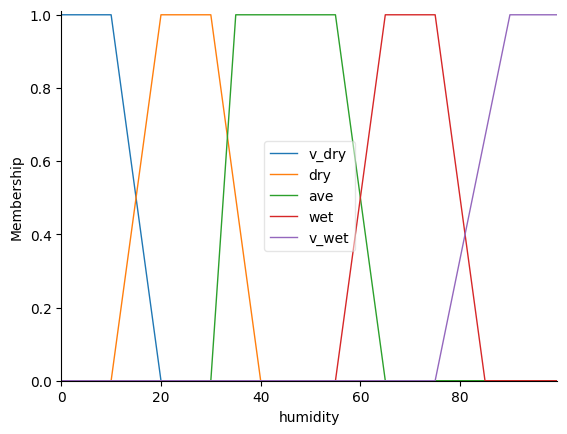

In [55]:
humidity.view()

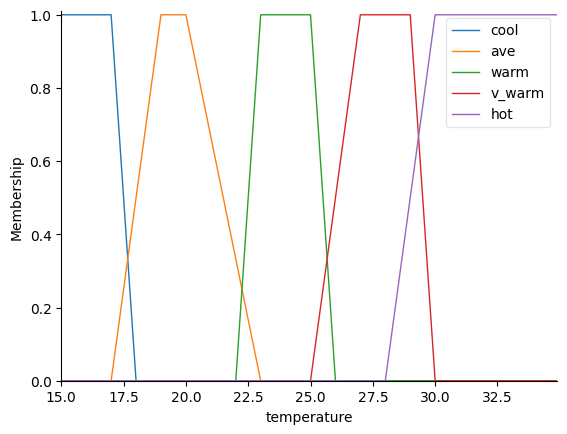

In [96]:
temperature.view()

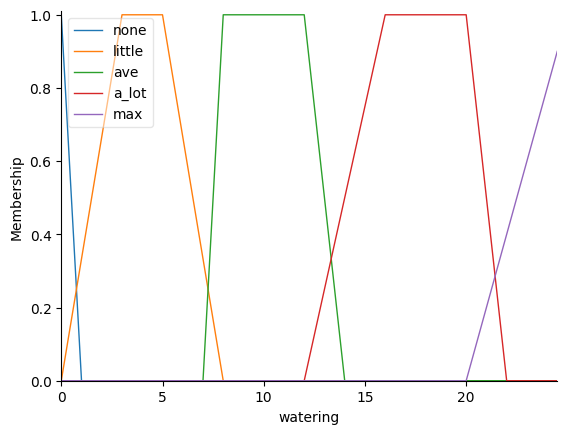

In [97]:
watering.view()

In [98]:
rule1 = ctrl.Rule((temperature['cool'] | temperature['ave'] | temperature['warm']) & humidity['v_wet'], watering['none'])
rule2 = ctrl.Rule(((temperature['v_warm'] | temperature['hot']) & humidity['v_wet']) | ((temperature['v_warm'] |  temperature['warm']) & humidity['wet']), watering['little'])
rule3 = ctrl.Rule((humidity['wet'] & temperature['hot']) | (humidity['ave'] & (temperature['ave'] | temperature['warm'])), watering['ave'])
rule4 = ctrl.Rule((humidity['v_dry'] & (temperature['cool'] | temperature['ave'] | temperature['warm'])) | (humidity['dry'] & (temperature['warm'] | temperature['v_warm'] )) | (humidity['ave'] & (temperature['v_warm'] | temperature['hot'])), watering['a_lot'])
rule5 = ctrl.Rule((humidity['v_dry'] & (temperature['hot']) | temperature['v_warm']) | (humidity['dry'] & temperature['hot']), watering['max'])

control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])

model = ctrl.ControlSystemSimulation(control_system)


Model proponuje nawodnienie:  7.122516556291755


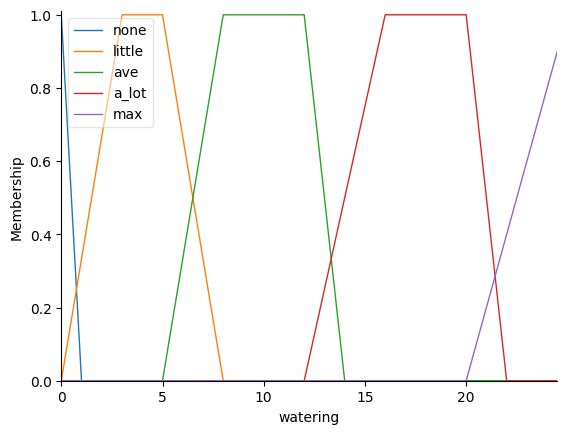

In [105]:
# możemy już przejść do faktycznego wykorzystywania wyniku
# powiedzmy, że jest godzina 13:30 i w galerii jest 3200 ludzi
model.input['temperature'] = 25
model.input['humidity'] = 60

# oblicz:
model.compute()

# wypisz wynik i przedstaw wynik graficznie:
print('Model proponuje nawodnienie: ',model.output['watering'])
watering.view(sim=model)

In [106]:
# możemy narysować wyniki dla różnych wejść np. na heatmapie:
import seaborn as sns
import pandas as pd

temp_grid, hum_grid = np.meshgrid(np.arange(15, 35, 0.1), np.arange(0, 100, 0.5))
test_points = np.transpose(np.vstack((np.ravel(temp_grid),np.ravel(hum_grid))))



model.input['temperature'] = test_points[:,0]
model.input['humidity'] = test_points[:,1]
model.compute()

# test_points = np.concatenate((test_points, model.output['watering'].reshape(-1,1)), axis=1)

# sns.heatmap(pd.DataFrame(test_points, columns = ['temperature','humidity','watering']).pivot(index='temperature', columns='humidity', values='watering'), cmap = 'coolwarm')

AssertionError: Total area is zero in defuzzification!

In [67]:
test_points[:,1]


array([ 0. ,  0. ,  0. , ..., 99.5, 99.5, 99.5])